In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from torch_unet.tools.dataset import TrainingSet, TestSet
from torch_unet.unet import UNet
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
import torch
import logging
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torch_unet.tools.evaluation import eval_net
from torchsummary import summary
from torch_unet.tools.losses import DiceCoeff

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
DATADIR = "../Datasets/training/"
IMAGE_DIR = DATADIR + "images/"
MASK_DIR = DATADIR + "groundtruth/"
MASK_THRESHOLD = 0.25


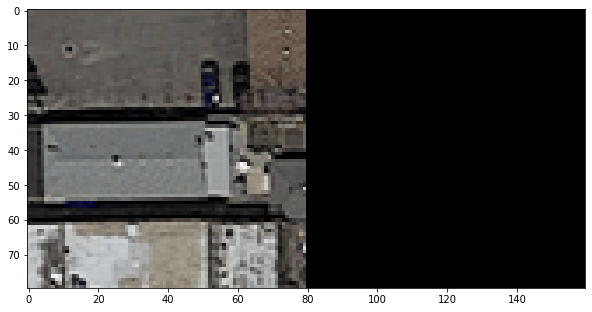

In [25]:
i = 2
img = dataset[i]['image'].detach().numpy().transpose((1,2,0))
mask = dataset[i]['mask'].detach().numpy()[0]
show_side_by_side(img, mask)

/home/tarek/Documents/Master_DS/ML/ML_course/projects/project2/project_road_segmentation/torch_unet/torch_unet/utils.py:7: RuntimeWarning: invalid value encountered in true_divide
  rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)


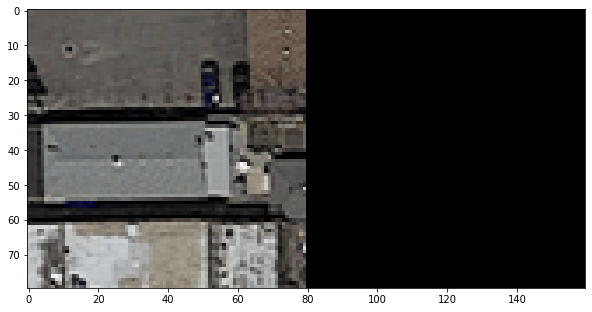

In [24]:
from torch_unet.utils import show_side_by_side


In [15]:
from torch_unet.pre_processing.patch import get_image_patches
patches = get_image_patches(img, 80, 20)

In [20]:
(patches.nbytes / 2**20) * 100

2116.69921875

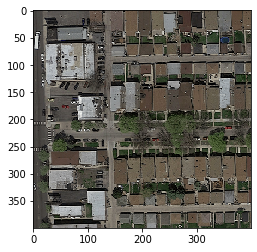

In [6]:
plt.imshow(img)

In [3]:
# Register device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')
net = UNet(n_channels=3, n_classes=1, depth=4, padding=True, init_filters=16, dropout=True)
net.to(device=device);

INFO: Using device cpu


In [6]:
summary(net, (3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 80, 80]             448
              ReLU-2           [-1, 16, 80, 80]               0
            Conv2d-3           [-1, 16, 80, 80]           2,320
              ReLU-4           [-1, 16, 80, 80]               0
        DoubleConv-5           [-1, 16, 80, 80]               0
         MaxPool2d-6           [-1, 16, 40, 40]               0
              Down-7  [[-1, 16, 40, 40], [-1, 16, 80, 80]]               0
            Conv2d-8           [-1, 32, 40, 40]           4,640
              ReLU-9           [-1, 32, 40, 40]               0
           Conv2d-10           [-1, 32, 40, 40]           9,248
             ReLU-11           [-1, 32, 40, 40]               0
       DoubleConv-12           [-1, 32, 40, 40]               0
        MaxPool2d-13           [-1, 32, 20, 20]               0
             Down-14  [[-1, 

In [42]:
net.load_state_dict(state_dict=torch.load("../models/depth4_BS128_lr0.001_PS80_ST20_padding_batchnorm_deca, dily_dropout0.2/checkpoints/CP_epoch23.pth", map_location=device))

<All keys matched successfully>

In [101]:
import cv2
def post_process_prediction(img):
    img_post = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel=np.ones((25, 25), np.uint8))
    #img_post = cv2.morphologyEx(img_post, cv2.MORPH_OPEN, kernel=np.ones((8, 8), np.uint8))
    #dilated = cv2.dilate(img_post, kernel=np.ones((2, 2), np.uint8), iterations=1)
    
    return img_post

In [102]:
i = 2
img = mpimg.imread(f"../Datasets/test_set_images/test_{i}.png")
mask = predict_full_image(net, img, device)
mask = (mask > 0.25) * 1

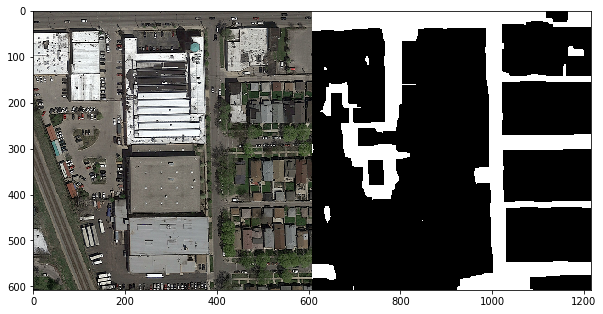

In [103]:
show_side_by_side(img, post_process_prediction(np.uint8(mask)))

In [7]:
import pandas as pd

In [14]:
submission = pd.read_csv("../Datasets/submission.csv")
solution = pd.read_csv("../Datasets/solution.csv").rename(columns={'prediction': 'actual'}).drop(columns=['Usage'])
merged = submission.merge(solution, on='id')

In [15]:
tp = merged[(merged['actual'] == 1) & (merged['prediction'] == 1)]['id'].count()
fn = merged[(merged['actual'] == 1) & (merged['prediction'] == 0)]['id'].count()
fp = merged[(merged['actual'] == 0) & (merged['prediction'] == 1)]['id'].count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [16]:
f1_score, precision, recall

(0.8746663819792889, 0.9091716140487155, 0.8426844947287221)

In [88]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

In [102]:
sigmoid = nn.Sigmoid()

t = np.round(np.random.rand(64))[:, None]
o = np.random.rand(64,1) - 0.5

t = Variable(torch.Tensor(t))
o = Variable(torch.Tensor(o))



In [104]:
print(nn.BCEWithLogitsLoss()(sigmoid(o), t))
print(nn.BCELoss()(sigmoid(o), t)) # Different numbers

tensor(0.7197)
tensor(0.6861)


In [99]:
t.shape

torch.Size([64, 1])

In [92]:
o.shape

torch.Size([64, 1])